<a href="https://colab.research.google.com/github/lingchm/datascience/blob/master/exercises/signal_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decomposing Heat Transfer

*svd*, *high-dimensional data*, *video*, *tensor*

**Problem**

An image is generated from the following heat transfer process:

$$\frac{\partial S_i}{\partial t} = \alpha_i \left(  \frac{\partial^2 S_i}{\partial x^2} + \frac{\partial^2 S_i}{\partial y^2} \right ),$$

where $ \alpha_i \tilde{} unif \{ 0.5 \cdot 10^{-5}, 1.5 \cdot 10^{-5} \}$ is the thermal diffusivity coefficient. In simple words, the heat spreads across the 2D plane (x and y axis) and across time. 

We will use simulation data created from equation (1). We add noise $\epsilon \tilde{} N(0, 0.01)$ to each pixel. 

Each sample is a short video over time composed of image frames. The goal is to reduce the dimensions of this HD video and extract key components that allow for interpretation and further analysis.


**Method**

We use a tensor to represent the HD video. Several tensor decomposition methods can be used to extract a lower dimensional representation of the video. Here, we demonstrate two popular tensor decomposition methods:
* CP decomposition factorizes a tensor into a sum of component rank-one tensors. The solution is exact and unique. 
* Tucker decomposition decomposes a tensor into a core tensor multiplied by a set of column-wise orthognal factorizing matrices along each mode. 

**References**

Credits to Dr. Kamran Paynabar for this demo. 

In [12]:
import matplotlib.pyplot as plt
import tensorly as tl
from itertools import product
import numpy as np
import tensorly.decomposition

In [5]:
# parameters
L = 0.05
H = 0.05
dx = 0.0025
dy = 0.0025
tmax = 10
dt = 0.01
epsilon = 0.0001
alpha = 0.5e-5+np.random.random()*1e-5

## Generating simulation data

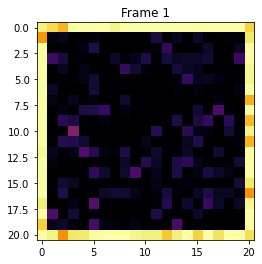

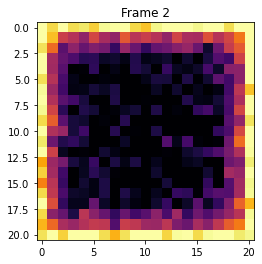

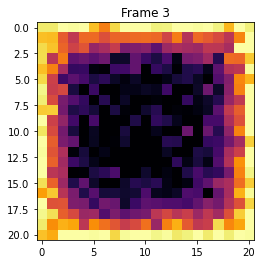

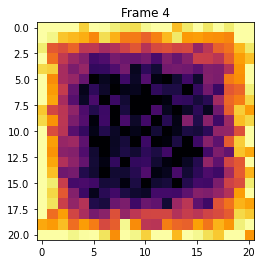

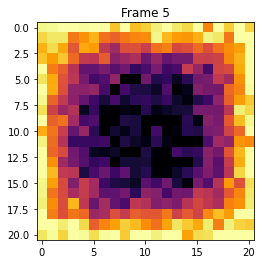

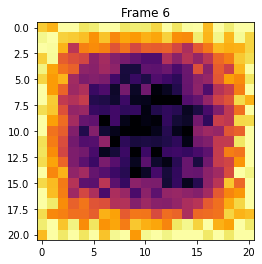

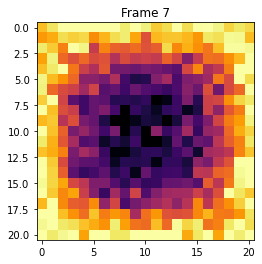

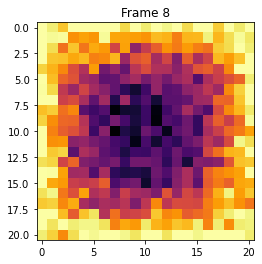

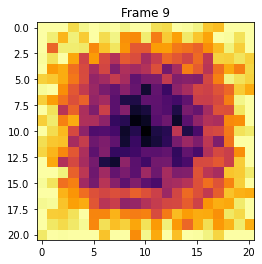

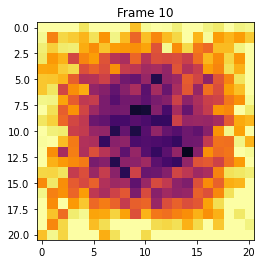

In [6]:
# simulate data 
SimulateData = []
SimulateDataNoNoise = []

# define physical equations 
r_x = alpha*dt/dx**2
r_y = alpha*dt/dy**2
fo = r_x + r_y

if fo > 0.5:
    msg = f'Current Fo = {fo}, which is numerically unstable (>0.5)'
    raise ValueError(msg)
    
# x, y meshgrid based on dx, dy
nx = int(L/dx + 1)
ny = int(H/dy + 1)
X, Y = np.meshgrid(np.linspace(0, L, nx), np.linspace(0, H, ny))

# center point of the domain
ic = int((nx-1)/2)
jc = int((ny-1)/2)

# initial and boundary conditions
S = np.zeros((ny, nx))

def enforceBdy(S):
    ''' Enforces the boundary conditions on S, the temperature values on the domain's grid points'''
    S[:, 0] = 1
    S[:, -1] = 1
    S[0, :] = 1
    S[-1, :] = 1
    return S

S = enforceBdy(S)

def Laplace(T):
    '''Computes the Laplacian operator, del-squared on the temperature data'''
    tmp_x, tmp_y = np.gradient(T, dx, dy)
    tmp_x, _ = np.gradient(tmp_x, dx)
    _, tmp_y = np.gradient(tmp_y, dy)
    return tmp_x+tmp_y

# iteration
nmax = int(tmax/dt)
for n in range(nmax):
    dSdt = alpha*Laplace(S)
    S = S + dSdt*dt
    S = enforceBdy(S)
    if n % 100 == 0:
        noise = np.random.normal(size=S.shape)*.1
        SimulateData.append(S.copy()+noise)
        SimulateDataNoNoise.append(S.copy())
    # check for convergence
    err = np.abs(dSdt*dt).max()
    if err <= epsilon:
        break

for i, frame in enumerate(SimulateData):
    plt.imshow(frame, vmin=0, vmax=1, cmap='inferno')
    plt.title(f'Frame {i+1}')
    plt.show()

In [24]:
# Creates Tensor
X = np.stack(SimulateData, 2)
nx,ny,nt = X.shape
X = tl.tensor(X)
X.shape

(21, 21, 10)

## CP decomposition

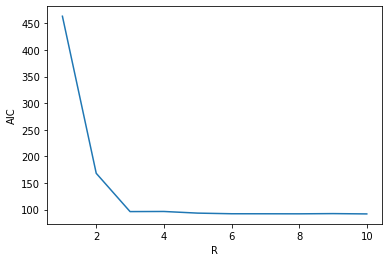

Best k: 3  min AIC: 246.33580796617622


In [72]:
# CP Decomposition
err = []
for i in range(1,11):
    CP_Heat = tl.decomposition.parafac(X,i)
    reconstructed = tl.kruskal_to_tensor(CP_Heat)  
    err.append(((X-reconstructed)**2).sum())

# select k using AIC = error + complexity 
AIC1 = [2*e + 2*(i+1) for i,e in enumerate(err)]
AIC2 = [2*e + (i+1)*nx+(i+1)*ny+(i+1)*nt for i,e in enumerate(err)]
AIC = AIC2
idxmin = np.argmin(AIC)
R = idxmin+1
min_AIC = AIC[idxmin]
plt.plot(np.arange(1,11),AIC1)
plt.xlabel('R')
plt.ylabel('AIC')
plt.show()
print("Best k:", R, " min AIC:", min_AIC)

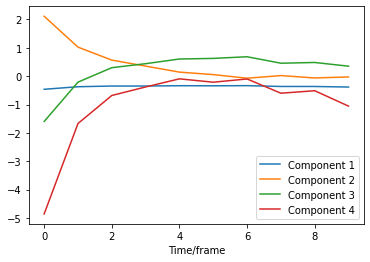

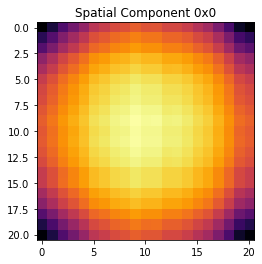

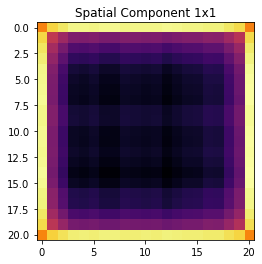

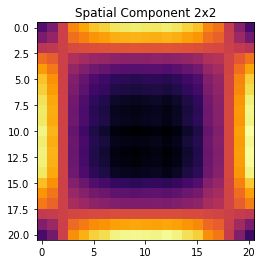

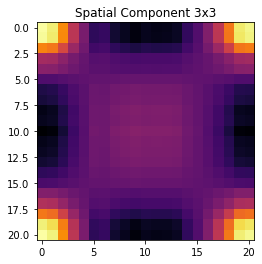

In [86]:
R=4
P = tl.decomposition.parafac(X,R) # P is (weights, factors)
plt.figure()
plt.plot(P[1][2])
plt.xlabel('Time/frame')
plt.legend(['Component ' +str(i) for i in range(1,R+1)])
plt.show()

# Question 
for i in range(R):
    A = P[1][0][:,i]
    B = P[1][1][:,i] # B = P[1][0][:,i] 
    XY = np.outer(A,B)
    plt.imshow(XY,cmap='inferno')
    plt.title(f'Spatial Component {i}x{i}')
    plt.show()

## Tucker decomposition

In [87]:
# Tucker Decomposition
AIC = {}
for i,j,k in product(range(1,5),repeat=3):
    tucker_heat = tl.decomposition.tucker(X,[i,j,k])
    reconstructed = tl.tucker_to_tensor(tucker_heat)  
    e = ((X-reconstructed)**2).sum()
    n_params = i*j*k+np.prod(tucker_heat[1][0].shape)+np.prod(tucker_heat[1][1].shape)+np.prod(tucker_heat[1][2].shape)
    AIC[(i,j,k)] = 2*e + 2*n_params

# find best truncation parameter 
minIJK = min(AIC,key=AIC.get)
# minIJK = (3,3,3)
minAIC = AIC[minIJK]
tucker = tl.decomposition.tucker(X,minIJK)
I,J,K = minIJK
print("Best (I,J,K):(", I,J,K, ")  min AIC:", min_AIC)

Best (I,J,K):( 2 2 2 )  min AIC: 246.33580796617622


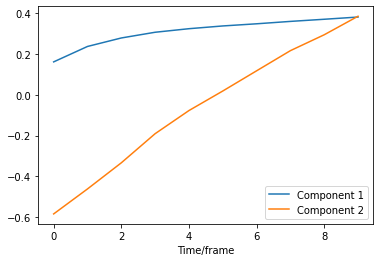

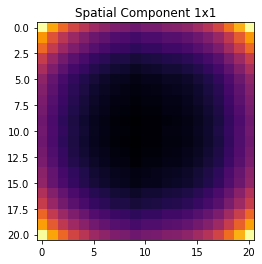

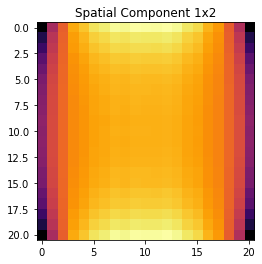

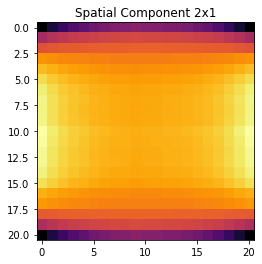

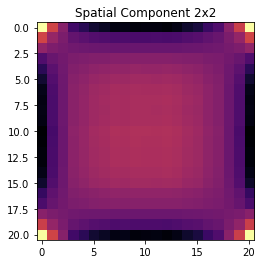

In [89]:
# Question 
plt.figure()
plt.plot(tucker[1][-1])
plt.xlabel('Time/frame')
plt.legend(['Component ' +str(i) for i in range(1,K+1)])
plt.show()
for i,j in product(range(I),range(J)):
    A = tucker[1][0][:,i]
    B = tucker[1][1][:,j] # A = tucker[1][1][:,j] 
    XY = np.outer(A,B)
    plt.imshow(XY,cmap='inferno')
    plt.title(f'Spatial Component {i+1}x{j+1}')
    plt.show()